In [1]:
#basic
import requests, time, os, re, string, wordcloud, spacy
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter

# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#scraping
from bs4 import BeautifulSoup

#visualization
from matplotlib import pyplot as plt
%matplotlib inline

#### define the artist for analysis and add artist page on lyrics.com

In [2]:
df_artist = pd.DataFrame(columns=["name", "url"], 
                         data=[
                               ["FrankOcean", "https://www.lyrics.com/artist.php?name=Frank-Ocean&aid=2295304&o=1"],
                               ["R.E.M.","https://www.lyrics.com/artist.php?name=R.E.M.&aid=116437&o=1"],
                               ["Robyn","https://www.lyrics.com/artist.php?name=Robyn&aid=214508&o=1"]
                              ])

In [3]:
df_artist

name                                                url
0  FrankOcean  https://www.lyrics.com/artist.php?name=Frank-O...
1      R.E.M.  https://www.lyrics.com/artist.php?name=R.E.M.&...
2       Robyn  https://www.lyrics.com/artist.php?name=Robyn&a...

In [4]:
# define lyrics folder
root = Path("C:/Users/steff/Documents/DataScience Bootcamp/Spiced Week 4/", "lyrics")

In [5]:
def get_artist_page(url):
    """
    connects to artist overview html and creates soup document
    """
    response = requests.get(url)
    page = str(BeautifulSoup(response.content))
    soup = BeautifulSoup( page, "lxml")
    return soup 

In [6]:
def get_urls(soup):
    """
    get all URLs for each artist
    """
    lyrics = []
    tables = soup.find_all(class_='tdata')
    for t in tables:
        cells = t.find_all('td', class_="tal qx")
        for c in cells:
            links = c.find_all('a')
            for l in links:
                lyrics.append((l['href']))
    return lyrics

In [7]:
# work with list instead of df!!!
def parse_lyrics(df_lyrics):
    """
    save lyrics html pages locally
    """
    df_lyrics = pd.DataFrame(lyrics)
    df_lyrics = df_lyrics[df_lyrics[0].str.contains('lyric')]
    df_lyrics['url'] ='https://www.lyrics.com'+df_lyrics[0]
    df_url = df_lyrics['url']
    # parse all lyrics  and save as html files
    for url in df_url:
        time.sleep(10)
        response = requests.get(url)
        page = BeautifulSoup(response.content)
        page = page.prettify("utf-8")
        filename = url.rsplit('/', 2)[-2]+'_'+url.rsplit('/', 2)[-1]
        filename = re.sub('[^a-zA-Z0-9-_*.]', '', filename)
        with open(root / f'Lyrics_{filename}.html', "wb") as file:
            file.write(page)

In [8]:
def cleaning(soup):
    """
    function to clean html bodies
    """
    # filter only for body with lyrics
    lyric = soup.find(class_='lyric-body').get_text()
    #replace abc't 
    lyric = lyric.replace('\'t','t')
    #replace line breaks
    lyric = lyric.replace('\n',' ')
    #replace â
    lyric = lyric.replace('â','')
    #replace inã
    lyric = lyric.replace('inã','ing')
    # remove words shorter than 3 characters
    shortword = re.compile(r'\W*\b\w{1,3}\b')
    lyric = shortword.sub('', lyric)
    # convert into lower caps
    lyric = lyric.lower()
    # exclude numbers
    #lyric = ''.join(i for i in lyric if not i.isdigit())
    # special characters
    chars = re.escape(string.punctuation)
    lyric = re.sub(r'['+chars+']', '',lyric)
    return lyric

In [9]:
def merge_lyrics(df_artist):
    """
    generate list of lyrics  and another for artist in same length
    """
    artist_list = []
    lyrics_list = []
    for i in os.listdir('lyrics/'):
        artist = i.split('_')[1]
        artists_filter = list(df_artist['name'].values)
        if artist in artists_filter:
            soup = BeautifulSoup(open('lyrics/'+i), "html.parser")
            try:
                text = cleaning(soup)
                artist_list.append(artist)
                lyrics_list.append(text)
            except AttributeError:
                print(i, 'did not load')
                continue
    return artist_list,lyrics_list

#### webscraping the lyrics 

In [10]:
for index, row in df_artist.iterrows():
    soup = get_artist_page(row['url'])
    lyrics = get_urls(soup)    
    #parse_lyrics(lyrics)

#### generate list of lyrics  and another for artist in same length

In [11]:
artist_list = []
lyrics_list = []
for i in os.listdir('lyrics/'):
    artist = i.split('_')[1]
    artists_filter = list(df_artist['name'].values)
    if artist in artists_filter:
        #print(i)
        soup = BeautifulSoup(open('lyrics/'+i), "html.parser")
        #print(soup)
        try:
            text = cleaning(soup)
            #lyrics_corpus.append((artist,text))
            artist_list.append(artist)
            lyrics_list.append(text)
        except AttributeError:
            #print(i)
            continue

In [12]:
artist_list,lyrics_list = merge_lyrics(df_artist)

Lyrics_Robyn_BeMine.html did not load


In [13]:
# check for same length
len(artist_list),len(lyrics_list)

(378, 378)

In [14]:
df_corpus = pd.DataFrame({'artist': artist_list, 'lyrics': lyrics_list})
df_corpus.head(3)

artist                                             lyrics
0  FrankOcean   duplex orleans east writing everything dont t...
1  FrankOcean   took walk with palm trees daylight fell sangr...
2  FrankOcean  taxi driver shrink hour leave meter running ru...

#### Remove stopwords with Spacy

In [15]:
# Check pre-defined stop words
spacy_nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words: %s' % list(spacy_stopwords)[:10])

Number of stop words: 305
First ten stop words: ['empty', 'we', 'themselves', 'seemed', 'again', 'therein', 'toward', 'be', 'sixty', 'least']


In [16]:
df_corpus['lyrics'] = df_corpus['lyrics'].apply(lambda x: ' '.join([item for item in x.split() if item not in spacy_stopwords]))

In [17]:
df_corpus.head(3)

artist                                             lyrics
0  FrankOcean  duplex orleans east writing dont tell things d...
1  FrankOcean  took walk palm trees daylight fell sangria can...
2  FrankOcean  taxi driver shrink hour leave meter running ru...

#### wordcloud

In [18]:
def word_cloud(artist, lyric):
    # mask definition
    mask = np.zeros((500, 500, 3), np.uint8)
    mask.shape
    #mask[150:350,50:350,:] = 255  # masked out area
    #pic_mask = np.array(Image.open(path.join(d, "101014-robyn.jpg")))
    cloud = wordcloud.WordCloud(background_color="white",
                    max_words=150,
                    mask=mask,
                    #mask=pic_mask
                    collocations=False,  # calculates frequencies
                    contour_color='steelblue').generate(str(lyric)) # <-- lyrics is a string
                    # stop words are removed!
    # viusal
    plt.figure(figsize = (40,40))
    plt.imshow(cloud, interpolation='bilinear')
    plt.savefig(f'{artist}+wordcloud.png')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    # still needs filter on df for artist

FrankOcean


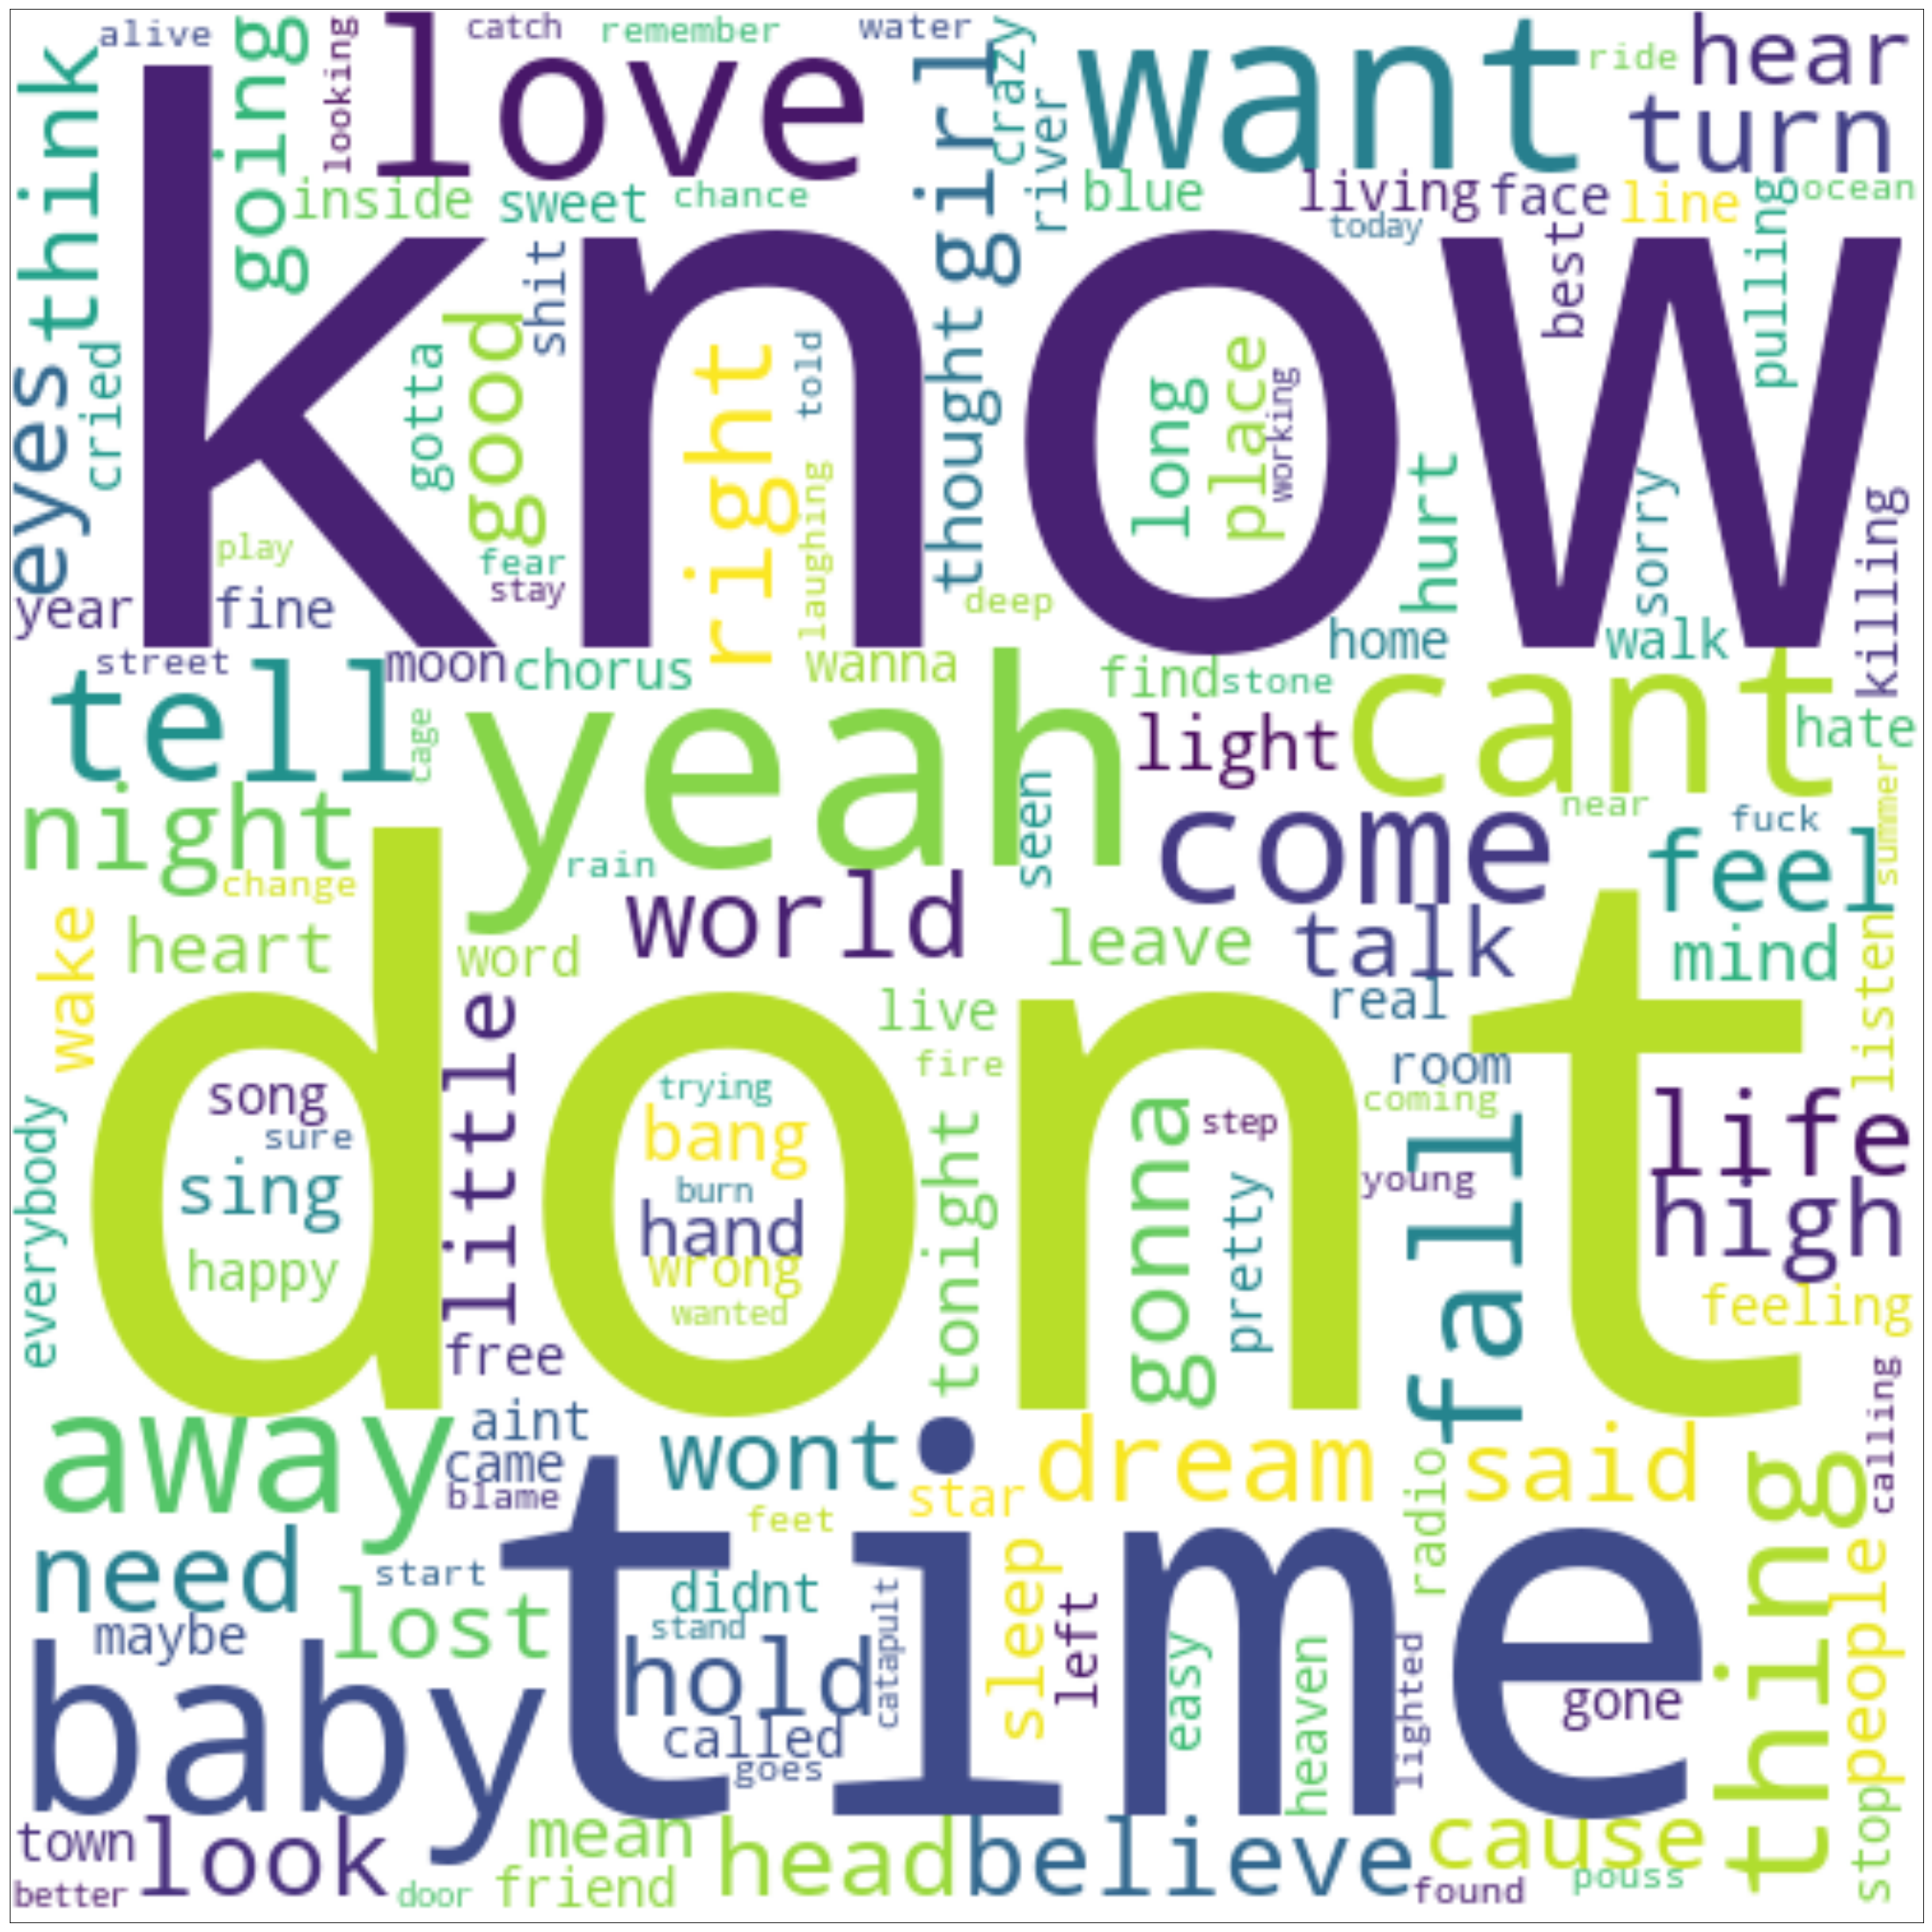

R.E.M.


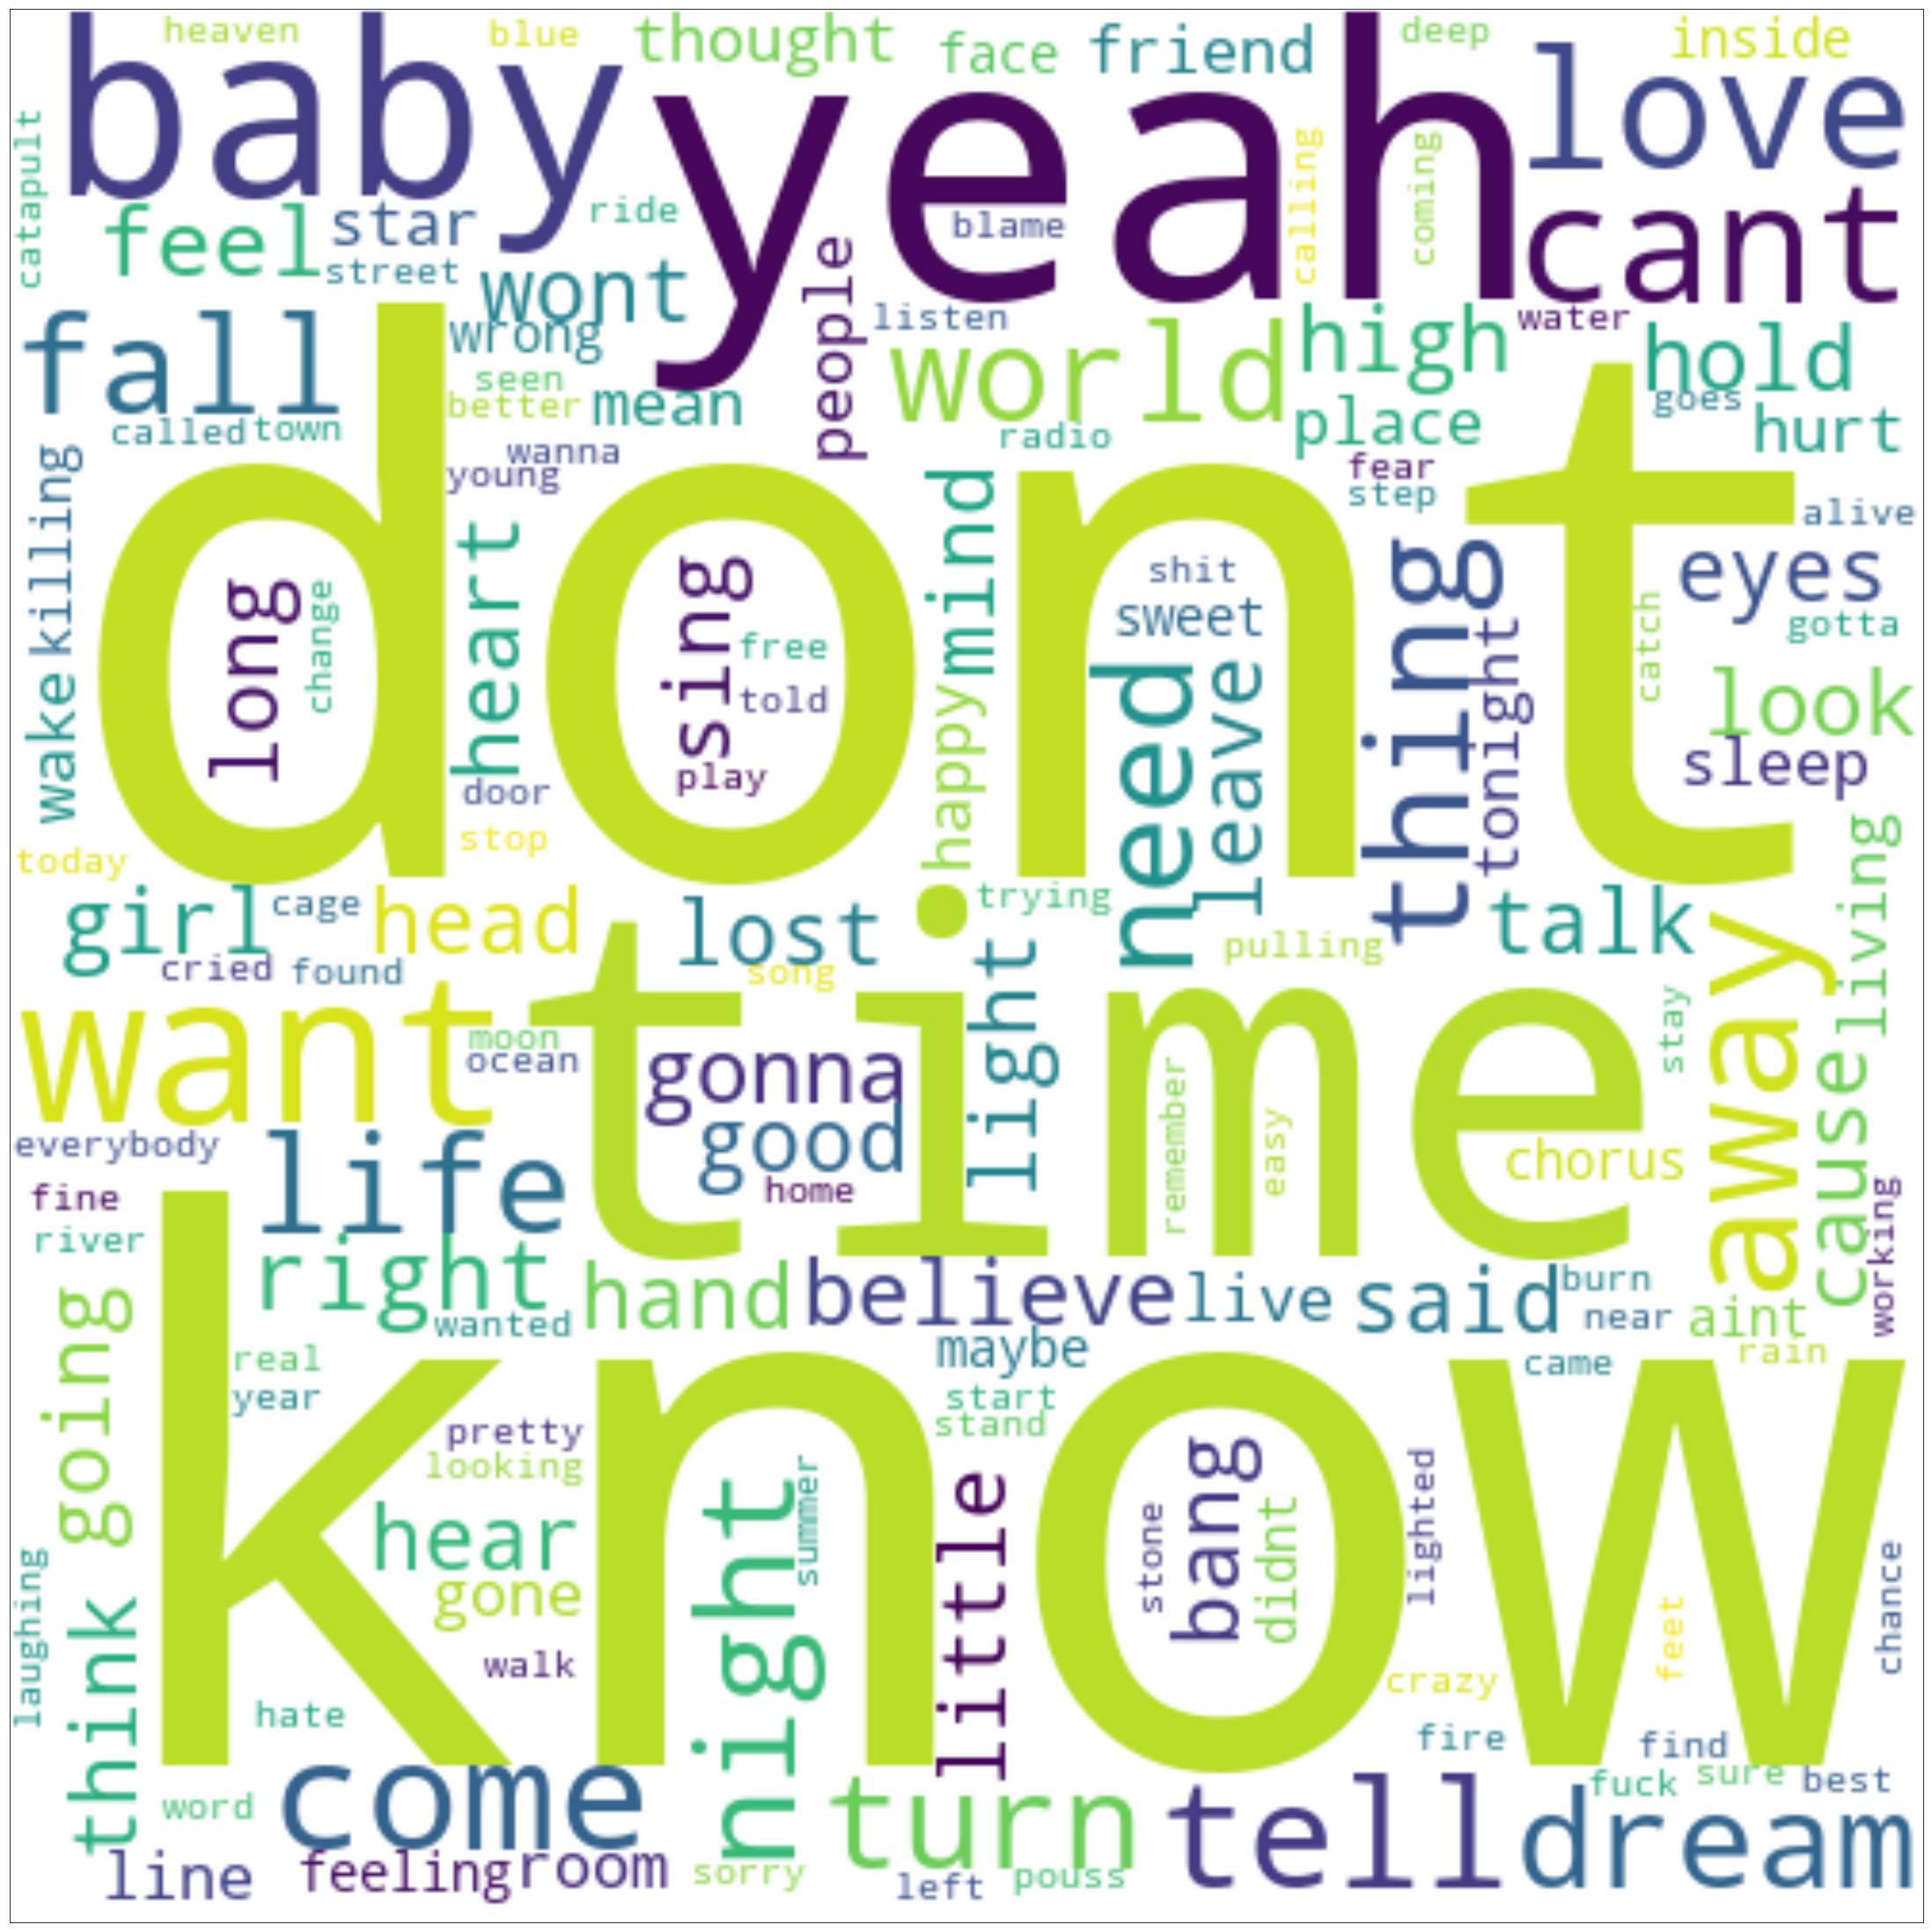

Robyn


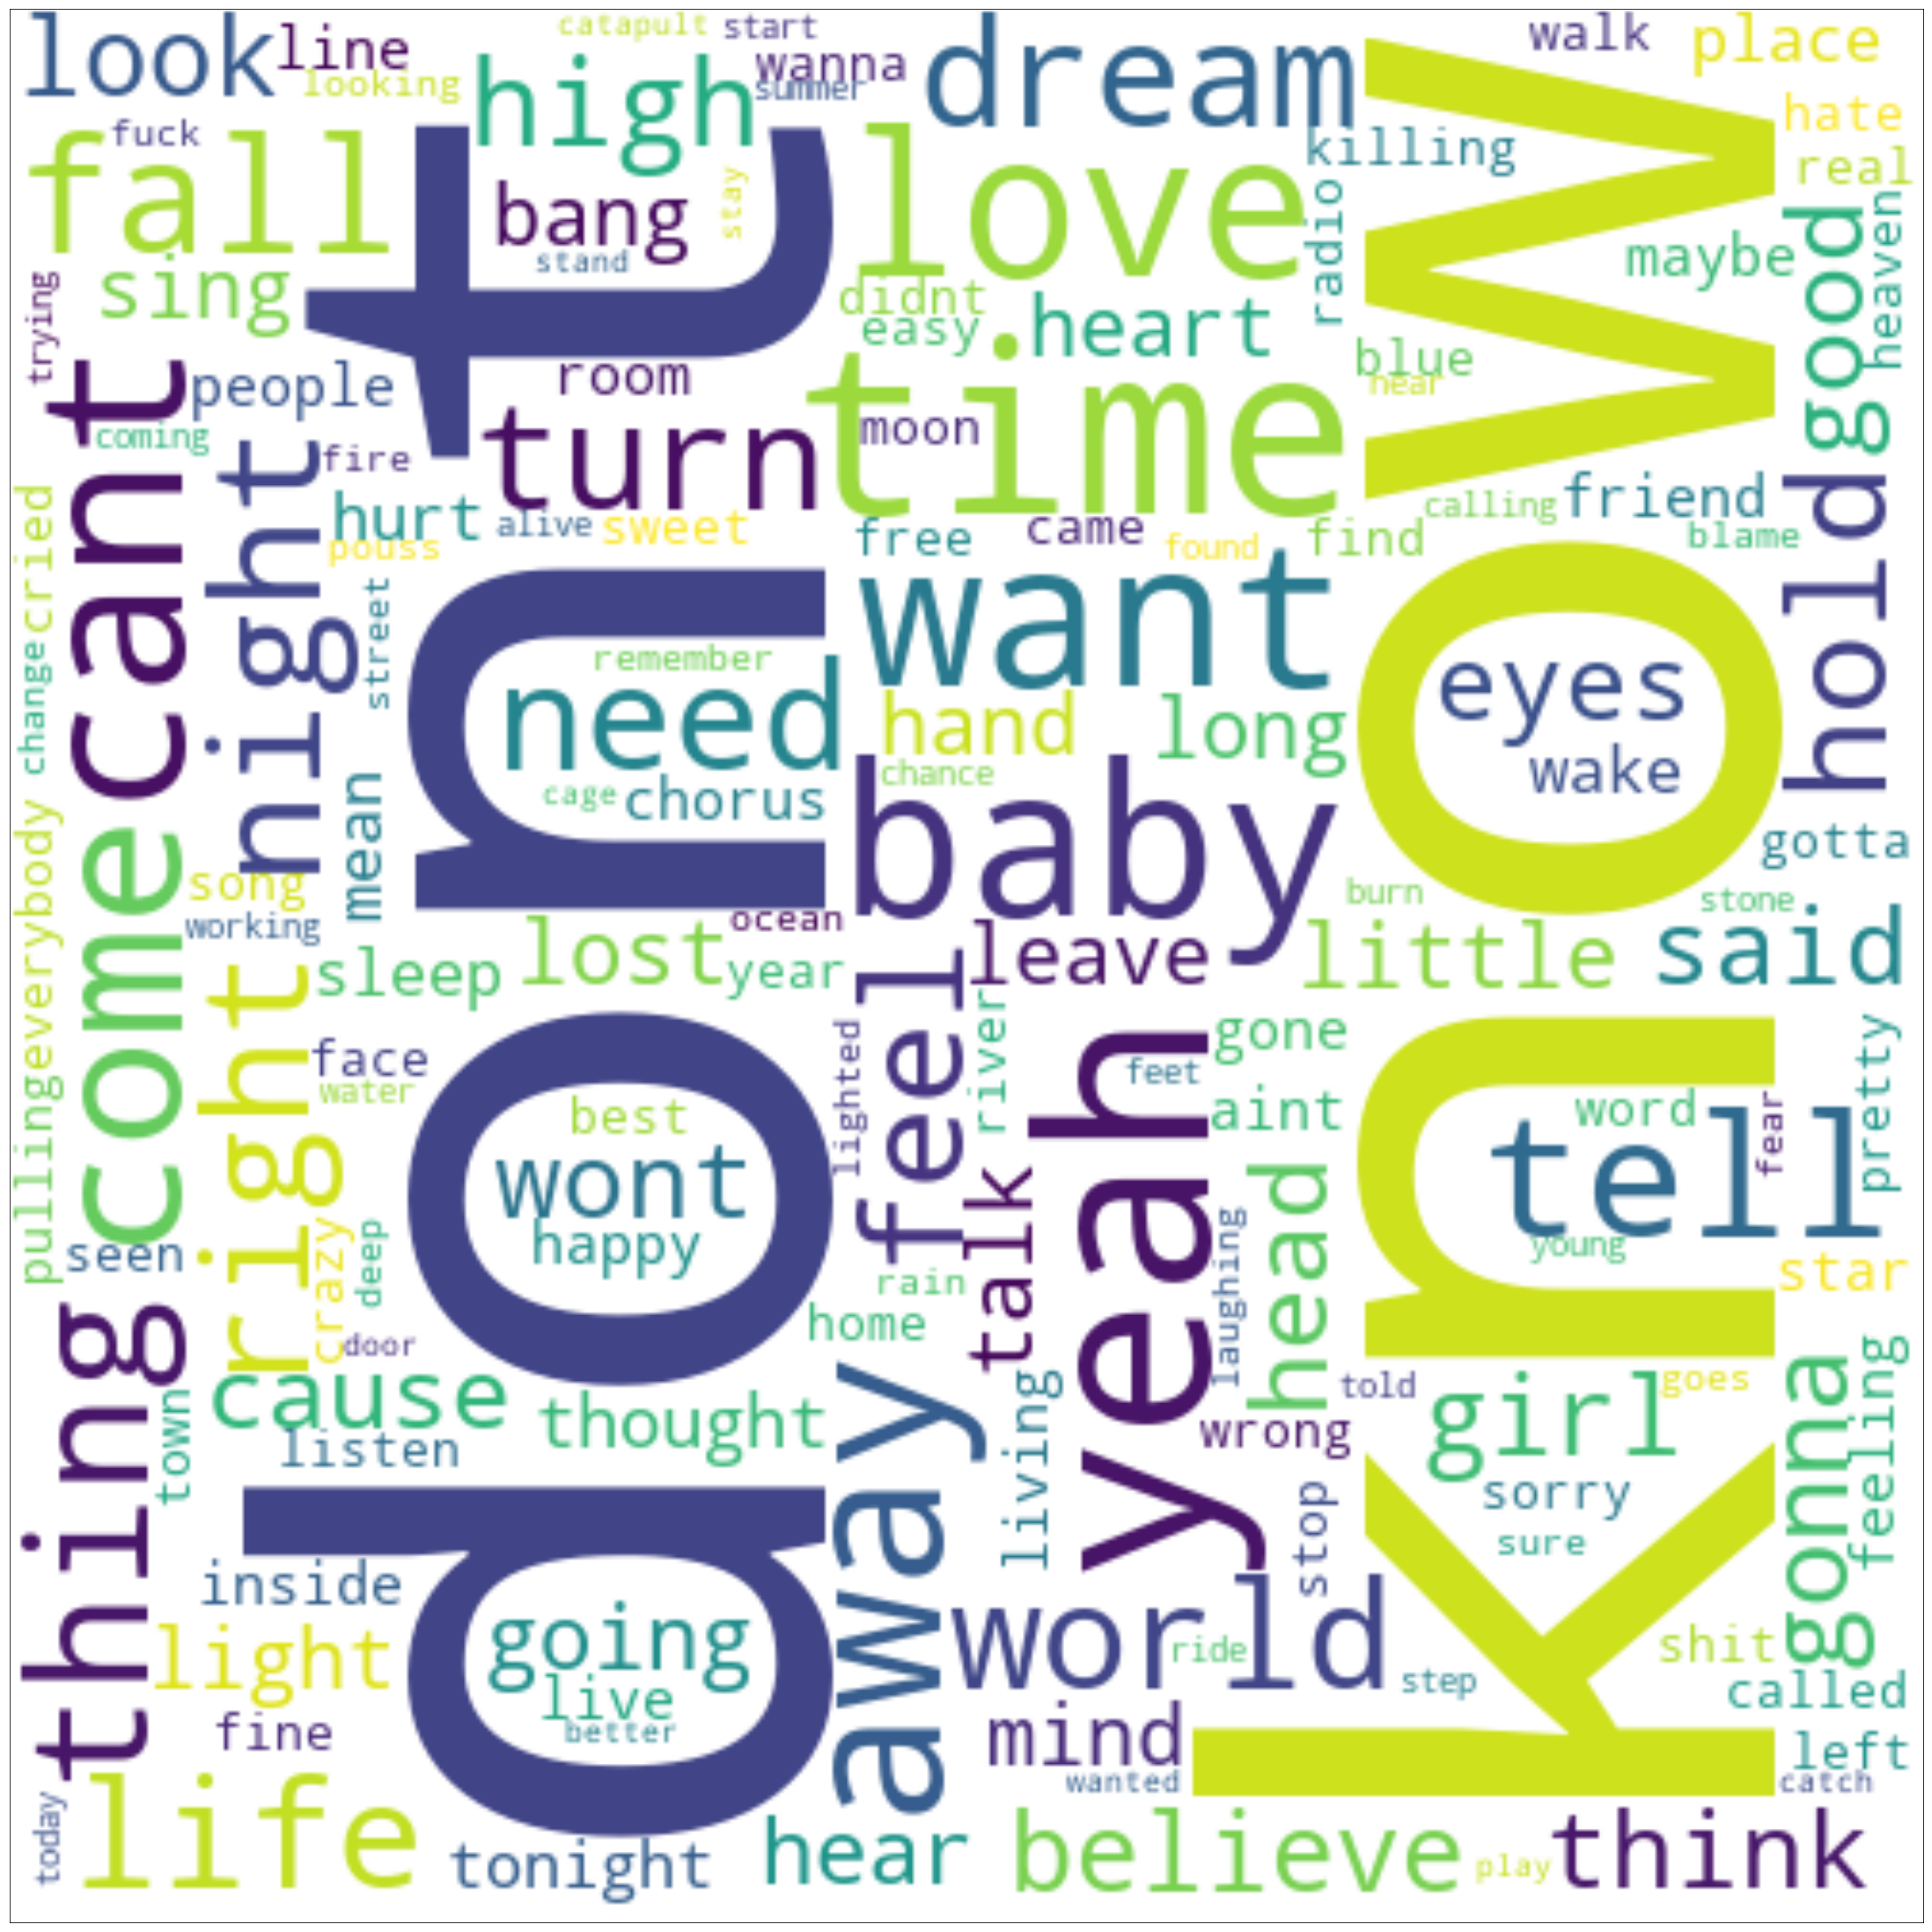

In [19]:
lyric = df_corpus.lyrics.values

for index, row in df_artist.iterrows():
    artist  = row['name']
    print(artist)
    word_cloud(artist,lyric)

#### most frequent words with a Counter 

In [20]:
for index, row in df_artist.iterrows():
    artist  = row['name']
    print(artist)
    c = list (Counter(" ".join(df_corpus['lyrics']).split(" ")).items()) 
    sorted_by_occ = sorted(c, key=lambda tup: tup[1], reverse=True)
    print(sorted_by_occ[:10])
# still needs filter on df for artist

FrankOcean
[('dont', 551), ('know', 522), ('yeah', 363), ('like', 339), ('time', 314), ('baby', 285), ('love', 248), ('cant', 247), ('away', 247), ('want', 215)]
R.E.M.
[('dont', 551), ('know', 522), ('yeah', 363), ('like', 339), ('time', 314), ('baby', 285), ('love', 248), ('cant', 247), ('away', 247), ('want', 215)]
Robyn
[('dont', 551), ('know', 522), ('yeah', 363), ('like', 339), ('time', 314), ('baby', 285), ('love', 248), ('cant', 247), ('away', 247), ('want', 215)]
